### Jeremy Kazimer
#### jdkazime@buffalo.edu
#### Assignment #6

---

#### _Import Statements_

As always, our import statements:

In [1]:
from matplotlib import pyplot as plt

import tensorflow_probability as tfp
import tensorflow as tf

#### _Introduction_

The premise of this problem is that you're at the University at Buffalo, with some affiliation to the school.  As such, you're required to get tested weekly; nothing particular traumatizing, just a mouth swab test.  On the day of the test, everything is normal...you tell the people collecting your test to have a nice day and you get something to eat immediately after.  

All is well! Until you get an email...an email from the university informing you that your pool tested positive.  Anxiety rushes in, like a horde of people enclosing you with nowhere to go.  How is this possible? You haven't interacted with anyone face-to-face for longer than 30 seconds! You can't stop thinking about it.  Could I be sick? Worse, could I have spread it to other people?  

The thoughts get worse...you're at the lowest point in the pandemic, so you decide to do some math...

#### _Solution_

First, it must be noted that the retelling above is not a true story; at some point I did have a positive pool result, but I did not respond by doing math.  Instead, I was just mildly anxious until I received my individual test.

Regardless, the purpose of this problem is to calculate the probability that you're infected with COVID-19, given that your pool tests positive.  This is a rather convoluted problem, albeit it may not seem so.  Namely, it is a conditional probability question.  

To begin, let's establish some variables.  First, the probability that you're infected given that the pool is positive will be represented by the variable
\begin{equation}
P(S | +)
\end{equation}

which is effectively asking: what is the probability that you're sick $S$ given that the pool is positive $+$? Well, it's not as simple as scalar multiplication.  There are a few things to consider here.  How accurate are these COVID-19 tests? What is the infection rate? Really, this can be solved using Bayes Equation such that
\begin{equation}
P( A | B ) = \dfrac{P(B | A) P(A) }{P(B)}
\end{equation}

Here, $P(A | B)$ is analogous to $P(S | +)$.  As such, $P(A)$ is equivalent to $P(S)$ and $P(B)$ is equivalent to $P(+)$.  Rewritten,
\begin{equation}
P(S | +) = \dfrac{P(+ | S) P(S)}{P(+)}
\end{equation}

Now that we've defined these variables, it's important to define the way that these variables take shape.  On this front, the probability of testing positive given that you're sick $P(+ | S)$ would just be the accuracy of the the tests.  This is because...well, if you know that you're sick, then the test should detect that you're positive.  This is not always the case.  A [cursory glance](https://www.healthline.com/health-news/noninvasive-saliva-tests-for-covid-19-as-effective-as-nose-throat-swabs#What-experts-think) shows that the accuracy of the mouth swab test is
\begin{equation}
P(+ | S) = 83\%
\end{equation}

In [6]:
acc = 83/100

The probability of getting sick $P(S)$ then would just be the infection rate; the name is a bit misleading, but it's really an approximation to how many people are out there with COVID-19.  Since there isn't quite an exact statistic on the likelihood of getting COVID-19, this approximation will have to do.  Erie County's [COVID-19 page](https://covidactnow.org/us/new_york-ny/county/erie_county/?s=1749670) puts this value at
\begin{equation}
P(S) = 1.11 \%
\end{equation}

In [7]:
inf = 1.11/100

Lastly, the probablity of testing positive is a bit complicated.  Since there are 12 people in each pool, if the pool tests positive it doesn't specify the amount of people that tested positive.  So, it could be 1 person.  Or it could be them all! Who knows.  This is just because pooled samples don't quite allow for that precision.  Regardless, we must treat this by looking at the probability function of a binomial distribution such that
\begin{equation}
P(n, k, p) = \begin{pmatrix} n \\ k \end{pmatrix} p^k (1 - p)^{n - k}
\end{equation}

Here, $n$ is the total number of people in the pool, 12, and $k$ is the number of people predicted to test positive.  Note that $p$ is really our positive test rate, since we're trying to predict how many people are going to, well, test positive.  As such,
\begin{equation}
P(+) = \begin{pmatrix} 12 \\ k \end{pmatrix} p^k (1 - p)^{12 - k}
\end{equation}

with $p = 10.3 \%$ from the same site as the infection rate.  One important consideration is that testing positive or negative affects all of these rates, so these values are not precisely accurate.  However, so many people are getting tested such that it shouldn't affect it on a large scale. 

In [8]:
tpr = 10.3/100

Regardless, we can use `tensorflow_probability` to construct our probability of being sick granted that the pool is positive.  We must use the CDF of the binomial distribution, which is just the sum of the odds up to that particular $k$:

In [52]:
def probability_infected(n_people, n_total, acc, inf, tpr):

    '''
    n_people -> number of people potentially positive
    n_total -> total number of people in pool
    acc -> accuracy of test
    inf -> infection rate
    tpr -> positive test rate
    '''

    binomial = tfp.distributions.Binomial(n_total, probs = tpr)
    denom = tf.reduce_sum([binomial.prob(i) for i in range(1, n_people + 1)])

    ''' We use the CDF (excluding zero) because it'll reflect the odds up to that point, as opposed to that by itself.'''

    return acc*inf/denom

So, after all of this...it begs the question:  what is the likelihood that one person is infected given a pool is positive?

In [53]:
print('odds of being sick give the pool is positive: {:.2f}%'.format(probability_infected(12, 12, acc, inf, tpr)*100))

odds of being sick give the pool is positive: 1.26%


Of course, this isn't really how this works...it should be a bit higher.  A lot, really.  I'm not sure if my numbers or means are off.  However, I think this is also just inherent to the Bayes method.  It seems counterintuitive.  Regardless, we can plot this for $k = \{1, 2, \dots, 12\}$ to show how our distribution trends:

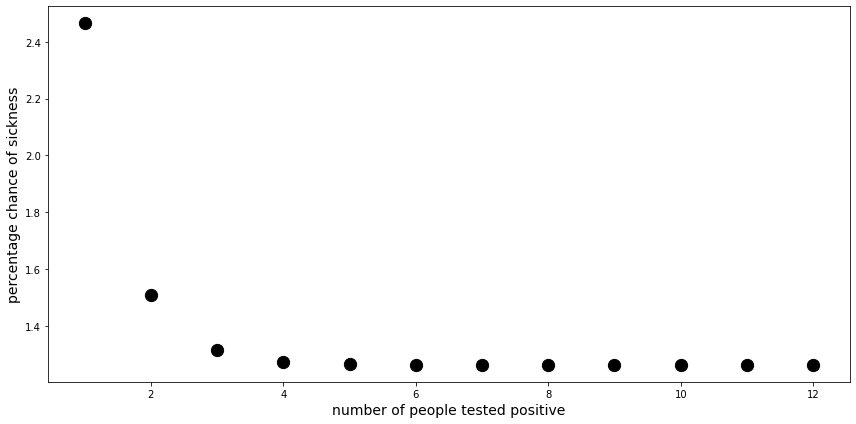

In [40]:
fig, ax = plt.subplots(1, 1, figsize = (12, 6))

ax.scatter(tf.range(1, 13), [100*probability_infected(i, 12, acc, inf, tpr) for i in range(1, 13)], s = 150, c = 'k')

ax.set_ylabel('percentage chance of sickness', fontsize = 14)
ax.set_xlabel('number of people tested positive', fontsize = 14)

fig.tight_layout()

Once again, counterintuitive.  You would anticipate that this trends upwards - but the probability decreases since the cumulative of $P(+)$ increases as $k$ increases.  Hmm, I don't know.

#### _Conclusion_
Well, if these odds are right, then the main character of this thrilling mystery tale has nothing to worry about.  I do think that this is wrong somewhere, or is at least showing me the failure of statistics as a quantitative field!

---